In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

In [3]:
# Data recovery
data=pd.read_csv("Fichier_Projet_DS_new.csv", sep= ';')

In [4]:
data.head()

,pmid,lead_time,initialmaincro,initialsubcro,finalmaincro,final_subcro,is_web_direct,flag_is_ota,booking_date,checkin_date,...,hotel_euro_market,environment_type,declared_stay_type,calculated_stay_type,is_all_member,type_member,is_member_ibis_business,is_member_business_plus,is_member_accor_plus,is_meeting_planner
0,1,6.0,INT,INT,NaN,INT,True,NaN,07/04/2021 07:30,13/04/2021 00:00,...,PACIFIC,None,business,business,1,ALL Gold,0,0,0,0
1,1,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,10/11/2021 00:00,...,PACIFIC,None,NaN,business,1,ALL Gold,0,0,0,0
2,1,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,23/03/2022 00:00,...,PACIFIC,None,NaN,business,1,ALL Gold,0,0,0,0
3,1,12.0,INT,INT,NaN,INT,True,NaN,25/02/2021 02:51,09/03/2021 00:00,...,PACIFIC,None,leisure,leisure,1,ALL Gold,0,0,0,0
4,1,24.0,INT,AFT,NaN,AFT,True,NaN,07/06/2022 01:48,01/07/2022 00:00,...,PACIFIC,None,leisure,leisure,1,ALL Gold,0,0,0,0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 66 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   pmid                      500000 non-null  int64  
 1   lead_time                 422480 non-null  float64
 2   initialmaincro            422480 non-null  object 
 3   initialsubcro             422480 non-null  object 
 4   finalmaincro              383560 non-null  object 
 5   final_subcro              439606 non-null  object 
 6   is_web_direct             500000 non-null  bool   
 7   flag_is_ota               176 non-null     float64
 8   booking_date              422480 non-null  object 
 9   checkin_date              500000 non-null  object 
 10  checkin_date_index        500000 non-null  int64  
 11  checkout_date             500000 non-null  object 
 12  checkout_date_index       500000 non-null  int64  
 13  stay_length               500000 non-null  i

In [6]:
# Calcul des doublons
data.duplicated().sum()

0

In [7]:
drop_columns = [ # Drop the too specific values not interesting for us
    'initialmaincro', 'initialsubcro', 'finalmaincro', 'final_subcro', 'bad_tr_ nb_nights', 
    'bad_tr_ turn_over_eur', 'hotelcode', 'hotel_name', 'rcu_codemarque', 'hotel_brand_code', 
    'hotel_zip_code', 'hotel_country', 'flag_is_ota', 'bad_tr_nbroomnights', 'flag_aberrante_value',
    'hotel_city', 'hotel_country_code',  # We keep only one payment data 'stay_catotal_eur'
    'bkg_catotal_eur','sb_catotal_eur','stay_cor_catotal_eur','tr_turn_over_eur','bad_tr_ turn_over_eur',
    'flag_aberrante_value','bkg_caroom_eur','stay_caroom_eur','stay_cor_caroom_eur','sb_caroom_eur',
    'checkout_date_index',   # the 'lead_time' and transformed dates by fonction 'organize_dates' are enough
    'nb_child', # The boolean 'child_presence' is enough    
    'bkg_nbnights','stay_nbnights','sb_nbnights','tr_nbnights', # Dropped after creation 'gap_bkg_stay_nights' value
    'bkg_nbroomnights','stay_nbroomnights','sb_nbroomnights','tr_nbroomnights' 
    # Dropped with no creation of a 'gap_bkg_stay_roomnights' value beacause we have 'gap_bkg_stay_nights'
]

dates_cols = ['booking_date', 'checkin_date', 'checkout_date']

boolean_cols = ['is_web_direct', 'child_presence', 'eligible_to_earn_points']


def organize_dates(data, dates_columns):  # To transform date and know if it's a day of the week or not
    for col in dates_columns:
        data[col] = pd.to_datetime(data[col])
        data[f'{col}_year']  = data[col].dt.year
        data[f'{col}_month'] = data[col].dt.month
        data[f'{col}_day_name'] = data[col].dt.day_name()
        data[f'{col}_is_weekend'] = np.where(data[f'{col}_day_name'].isin(['Saturday', 'Sunday']), 1, 0)
    return data.drop(dates_columns, axis=1)

def initial_preprocess_data(data, boolean_cols): 
# To transform true/false in 1/0
    for col in boolean_cols:
        data[col] = np.where(data[col]==True, 1, 0)
    return data

def initial_preprocessing_pipeline(data, dates_columns, boolean_cols, drop_columns):
    data = organize_dates(data, dates_columns)
    data = initial_preprocess_data(data, boolean_cols)
    return data.drop(drop_columns, axis=1)

In [12]:
# To know the potential difference of the number of nights between the reservation and the real stay (positiv or negativ or 0)
data['gap_bkg_stay_nights'] = data['bkg_nbroomnights'] - data['stay_nbroomnights']

In [8]:
data['hotel_brand_positionning'] = np.where(data['hotel_brand_positionning'] == 'Unknown Positioning', data['hotel_brand_code'], data['hotel_brand_positionning'])

In [9]:
# Organization of the Dates of the Dataset (format, day name, week-end)
# Boolean to number 0/1
# Drop unsused coloumns
data_explore = initial_preprocessing_pipeline(data=data, dates_columns=dates_cols, boolean_cols=boolean_cols, drop_columns=drop_columns)

In [15]:
data_explore.head()

,pmid,lead_time,is_web_direct,checkin_date_index,stay_length,booking_status,nb_adults,child_presence,eligible_to_earn_points,points,...,booking_date_day_name,booking_date_is_weekend,checkin_date_year,checkin_date_month,checkin_date_day_name,checkin_date_is_weekend,checkout_date_year,checkout_date_month,checkout_date_day_name,checkout_date_is_weekend
0,1,6.0,1,2,2,A,1.0,0,1,226,...,Sunday,1,2021,4,Tuesday,0,2021,4,Thursday,0
1,1,NaN,0,3,2,NaN,NaN,0,1,264,...,NaN,0,2021,10,Monday,0,2021,12,Saturday,1
2,1,NaN,0,3,1,NaN,NaN,0,1,119,...,NaN,0,2022,3,Wednesday,0,2022,3,Thursday,0
3,1,12.0,1,2,2,A,1.0,0,1,498,...,Thursday,0,2021,9,Friday,0,2021,11,Wednesday,0
4,1,24.0,1,5,1,A,1.0,0,1,142,...,Wednesday,0,2022,1,Friday,0,2022,2,Monday,0


In [16]:
data_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   pmid                      500000 non-null  int64  
 1   lead_time                 422480 non-null  float64
 2   is_web_direct             500000 non-null  int32  
 3   checkin_date_index        500000 non-null  int64  
 4   stay_length               500000 non-null  int64  
 5   booking_status            422480 non-null  object 
 6   nb_adults                 422480 non-null  float64
 7   child_presence            500000 non-null  int32  
 8   eligible_to_earn_points   500000 non-null  int32  
 9   points                    500000 non-null  int64  
 10  stay_catotal_eur          468236 non-null  float64
 11  hotel_brand               500000 non-null  object 
 12  hotel_brand_positionning  500000 non-null  object 
 13  hotel_rooms               500000 non-null  i

In [17]:
# On s'interesse aux modalités de chaque colonne
uniqueValues = data_explore.nunique()
print(uniqueValues)

pmid                        130957
lead_time                      506
is_web_direct                    2
checkin_date_index               7
stay_length                    120
booking_status                   3
nb_adults                       28
child_presence                   2
eligible_to_earn_points          2
points                        8887
stay_catotal_eur             80809
hotel_brand                     51
hotel_brand_positionning        31
hotel_rooms                    504
hotel_sales_organisation         8
hotel_class                     10
hotel_location_type              4
hotel_continent                  7
hotel_euro_market               10
environment_type                 5
declared_stay_type               3
calculated_stay_type             2
is_all_member                    2
type_member                     13
is_member_ibis_business          2
is_member_business_plus          2
is_member_accor_plus             2
is_meeting_planner               2
gap_bkg_stay_nights 

In [18]:
data_explore.describe()

,pmid,lead_time,is_web_direct,checkin_date_index,stay_length,nb_adults,child_presence,eligible_to_earn_points,points,stay_catotal_eur,...,gap_bkg_stay_nights,booking_date_year,booking_date_month,booking_date_is_weekend,checkin_date_year,checkin_date_month,checkin_date_is_weekend,checkout_date_year,checkout_date_month,checkout_date_is_weekend
count,500000.000000,422480.000000,500000.000000,500000.000000,500000.000000,422480.000000,500000.000000,500000.000000,500000.000000,468236.000000,...,395245.000000,422480.000000,422480.000000,500000.00000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,65085.346224,17.888234,0.613588,3.640690,1.876596,1.631183,0.068646,0.999648,591.218986,283.055802,...,-0.079338,2021.531585,6.368865,0.20008,2021.552322,6.559626,0.246212,2021.554632,6.573424,0.280268
std,37832.102477,35.082429,0.486927,1.957982,2.551059,0.893649,0.252851,0.018758,1394.415718,594.288224,...,1.679041,0.511242,3.233611,0.40006,0.497255,3.230314,0.430804,0.497007,3.238207,0.449131
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2015.000000,...,-279.000000,2018.000000,1.000000,0.00000,2021.000000,1.000000,0.000000,2021.000000,1.000000,0.000000
25%,32328.000000,1.000000,0.000000,2.000000,1.000000,1.000000,0.000000,1.000000,130.000000,90.000000,...,0.000000,2021.000000,4.000000,0.00000,2021.000000,4.000000,0.000000,2021.000000,4.000000,0.000000
50%,64866.500000,6.000000,1.000000,3.000000,1.000000,1.000000,0.000000,1.000000,284.000000,147.730000,...,0.000000,2022.000000,6.000000,0.00000,2022.000000,7.000000,0.000000,2022.000000,7.000000,0.000000
75%,97907.000000,19.000000,1.000000,5.000000,2.000000,2.000000,0.000000,1.000000,576.000000,286.830000,...,0.000000,2022.000000,9.000000,0.00000,2022.000000,9.000000,0.000000,2022.000000,9.000000,1.000000
max,130957.000000,1322.000000,1.000000,7.000000,323.000000,69.000000,1.000000,1.000000,111112.000000,46485.540000,...,627.000000,2022.000000,12.000000,1.00000,2022.000000,12.000000,1.000000,2022.000000,12.000000,1.000000


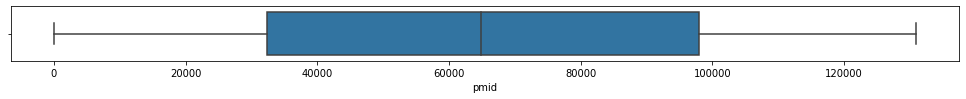

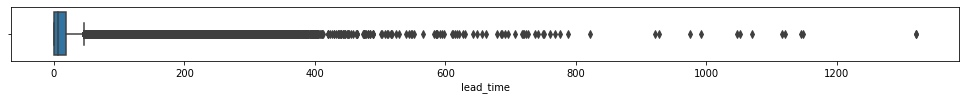

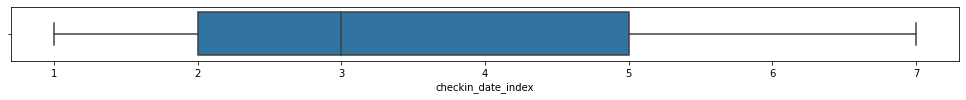

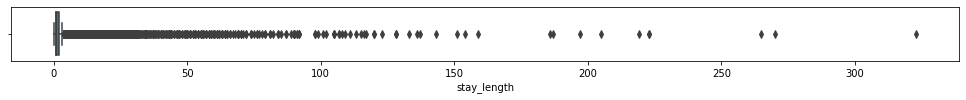

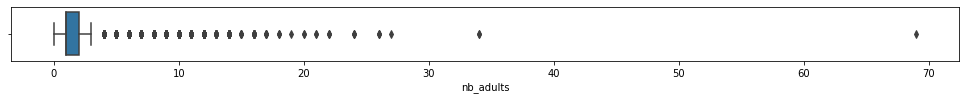

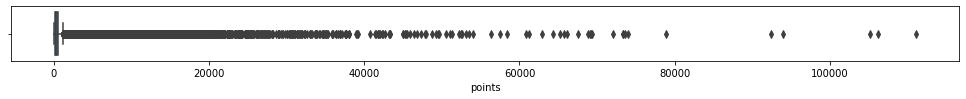

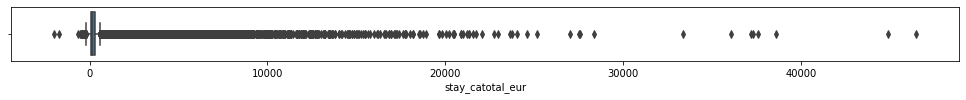

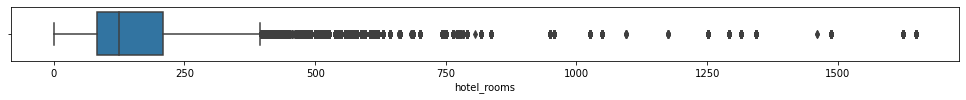

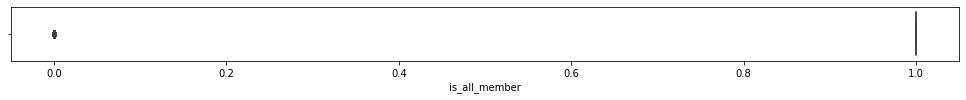

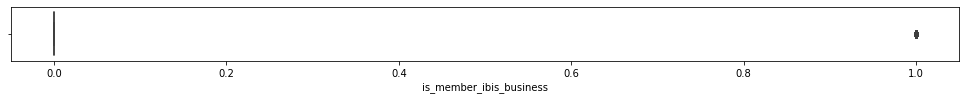

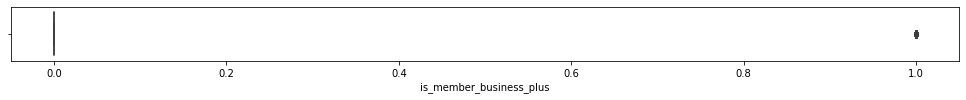

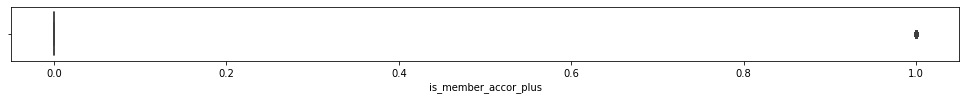

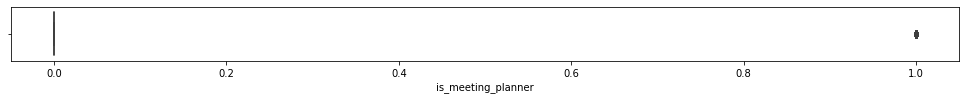

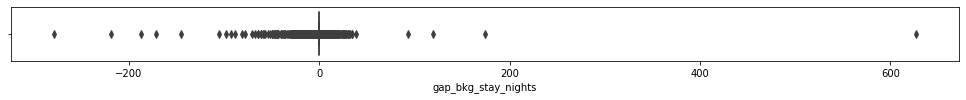

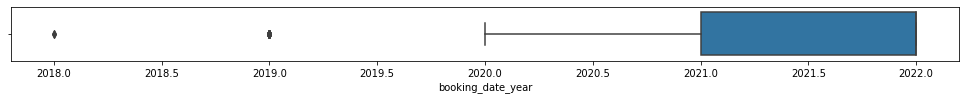

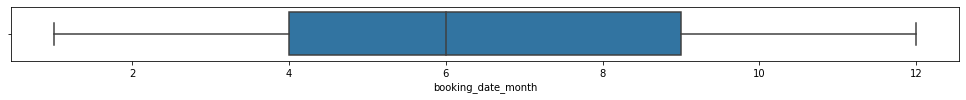

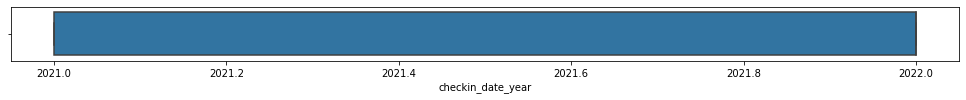

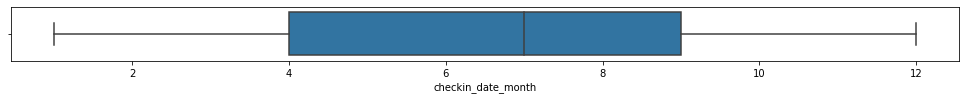

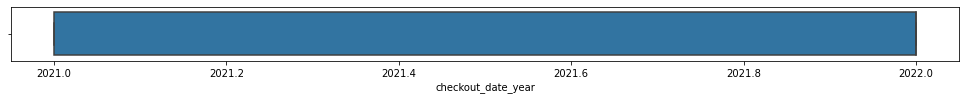

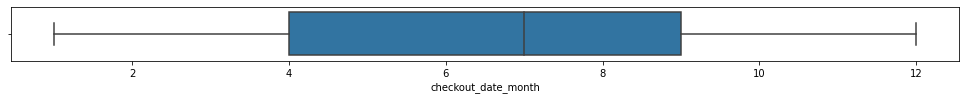

In [19]:
# Searching for outliers :
# The quartile method would risk removing good values if the sample is healthy to begin with
# The best thing to do is to look at the values individually with a professional eye.

df_num = data_explore.select_dtypes(include=['int64', 'float64'])
for column in df_num:
    plt.figure(figsize=(17,1))
    sns.boxplot(data=df_num, x=column)

# From a business point of view, a large 'stay_nbnights' (max 366 days, which is the case) means a person residing permanently at the hotel.
# In the same way that a large 'nb_child' can represent a stay to discover a school for example.
# As for the room rate 'stay_caroom_eur' it can be justified by an exceptional service (e.g. Eiffel Tower view).
# Thus the choice is made not to touch the values which could appear at first sight as aberrant.

Declared_stay_type
 None        0.413201
leisure     0.388092
business    0.198708
Name: declared_stay_type, dtype: float64
Calculated_stay_type
 business    0.57973
leisure     0.42027
Name: calculated_stay_type, dtype: float64


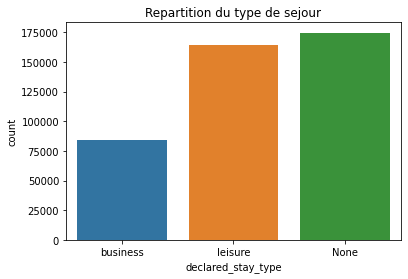

In [20]:
# Repartition des modalités de la variable cible
print("Declared_stay_type\n", data_explore['declared_stay_type'].value_counts(normalize=True))
print("Calculated_stay_type\n", data_explore['calculated_stay_type'].value_counts(normalize=True))

sns.countplot(x=data_explore['declared_stay_type'])
plt.title("Repartition du type de sejour");

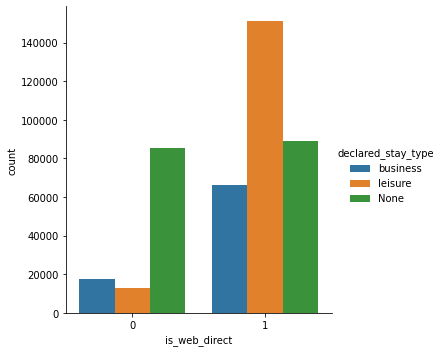

In [21]:
# is_web_direct
sns.catplot(x='is_web_direct', kind="count", hue='declared_stay_type', data=data_explore, sharey=False);

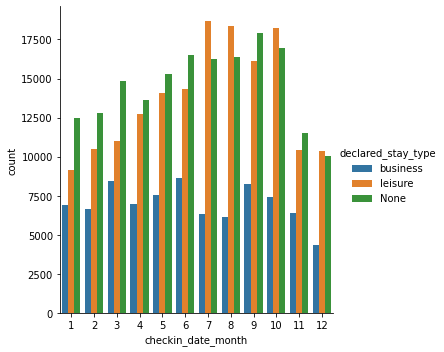

In [22]:
# checkin_date_month
sns.catplot(x='checkin_date_month', kind="count", hue='declared_stay_type', data=data_explore, sharey=False);

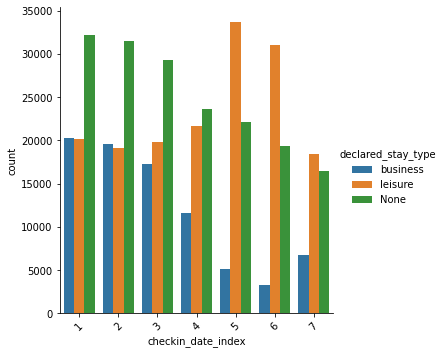

In [23]:
# checkin_date_index
chart = sns.catplot(x='checkin_date_index', kind="count", hue='declared_stay_type', data=data_explore, sharey=False);
chart.set_xticklabels(rotation=45)

In [24]:
# Quick Data Mining of a build value
data_explore['checkin_date_is_weekend'].value_counts()

0    376894
1    123106
Name: checkin_date_is_weekend, dtype: int64

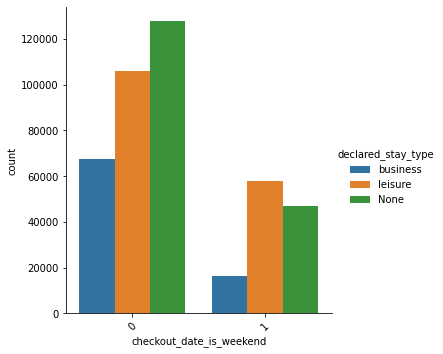

In [25]:
# checkin_date_is_weekend
chart = sns.catplot(x='checkout_date_is_weekend', kind="count", hue='declared_stay_type', data=data_explore, sharey=False);
chart.set_xticklabels(rotation=45)

[ 1  7 28]


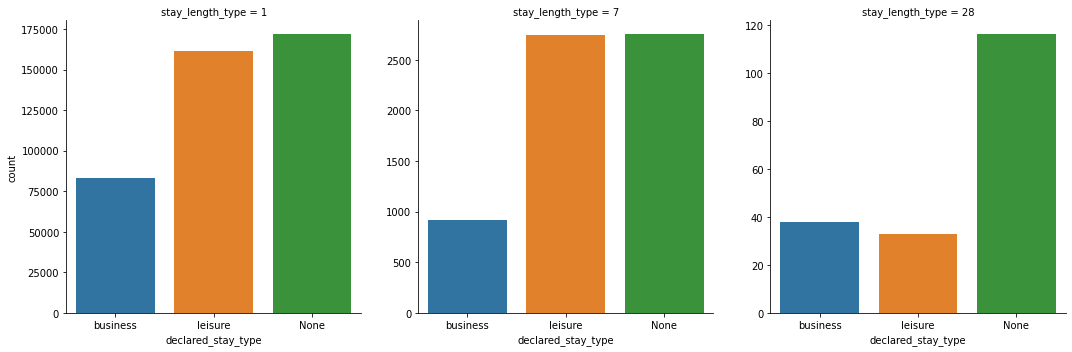

In [26]:
# stay_length
data_explore['stay_length_type'] = data_explore['stay_length']
data_explore['stay_length_type'] = np.where(data_explore['stay_length_type'] < 7, 1, data_explore['stay_length_type'])
data_explore['stay_length_type'] = np.where((data_explore['stay_length_type'] > 7) & (data_explore['stay_length_type'] < 28), 7, data_explore['stay_length_type'])
data_explore['stay_length_type'] = np.where(data_explore['stay_length_type'] > 28, 28, data_explore['stay_length_type'])

print(data_explore['stay_length_type'].unique())

sns.catplot(x='declared_stay_type', kind="count", col='stay_length_type', data=data_explore, sharey=False);

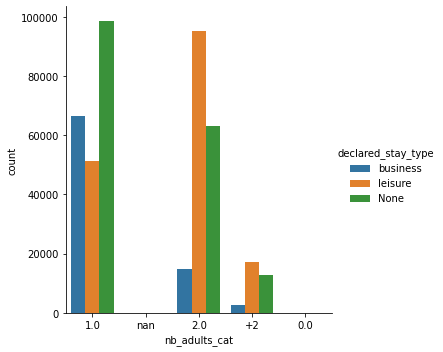

In [27]:
# nb_adults
import numpy as np

data_explore['nb_adults_cat'] = np.where(data_explore['nb_adults'] > 2, '+2', data_explore['nb_adults'])

sns.catplot(x='nb_adults_cat', kind="count", hue='declared_stay_type', data=data_explore, sharey=False);

In [28]:
# Quick Data Mining of a presumed essentiel value
data_explore['child_presence'].value_counts()

0    465677
1     34323
Name: child_presence, dtype: int64

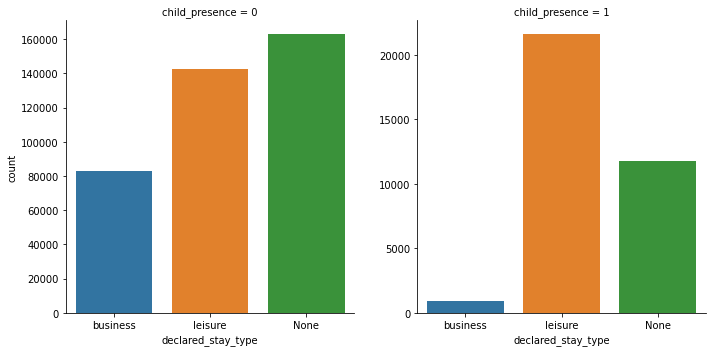

In [29]:
# child_presence
sns.catplot(x='declared_stay_type', kind="count", col='child_presence', data=data_explore, sharey=False);

In [10]:
# Cleaning : before check for null data
data_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 40 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   pmid                      500000 non-null  int64  
 1   lead_time                 422480 non-null  float64
 2   is_web_direct             500000 non-null  int32  
 3   checkin_date_index        500000 non-null  int64  
 4   stay_length               500000 non-null  int64  
 5   booking_status            422480 non-null  object 
 6   nb_adults                 422480 non-null  float64
 7   child_presence            500000 non-null  int32  
 8   eligible_to_earn_points   500000 non-null  int32  
 9   points                    500000 non-null  int64  
 10  stay_catotal_eur          468236 non-null  float64
 11  hotel_brand               500000 non-null  object 
 12  hotel_brand_positionning  500000 non-null  object 
 13  hotel_rooms               500000 non-null  i

In [11]:
encoded_data = data_explore.dropna() # To drop the NAN values

In [32]:
# Verification : no more null value
encoded_data.info()
# 388698 is a correct number of lines for working
# The sample size was 500.000 lines at the beginning but our project is not called PyCor for nothing ;-)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388714 entries, 0 to 499998
Data columns (total 43 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   pmid                      388714 non-null  int64  
 1   lead_time                 388714 non-null  float64
 2   is_web_direct             388714 non-null  int32  
 3   checkin_date_index        388714 non-null  int64  
 4   stay_length               388714 non-null  int64  
 5   booking_status            388714 non-null  object 
 6   nb_adults                 388714 non-null  float64
 7   child_presence            388714 non-null  int32  
 8   eligible_to_earn_points   388714 non-null  int32  
 9   points                    388714 non-null  int64  
 10  stay_catotal_eur          388714 non-null  float64
 11  hotel_brand               388714 non-null  object 
 12  hotel_brand_positionning  388714 non-null  object 
 13  hotel_rooms               388714 non-null  i

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228692 entries, 0 to 499994
Data columns (total 28 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   pmid                      228692 non-null  int64  
 1   lead_time                 228692 non-null  float64
 2   is_web_direct             228692 non-null  int32  
 3   checkin_date_index        228692 non-null  int64  
 4   stay_length               228692 non-null  int64  
 5   nb_adults                 228692 non-null  float64
 6   child_presence            228692 non-null  int32  
 7   eligible_to_earn_points   228692 non-null  int32  
 8   points                    228692 non-null  int64  
 9   stay_catotal_eur          228692 non-null  float64
 10  hotel_rooms               228692 non-null  int64  
 11  declared_stay_type        228692 non-null  int64  
 12  is_all_member             228692 non-null  int64  
 13  is_member_ibis_business   228692 non-null  i

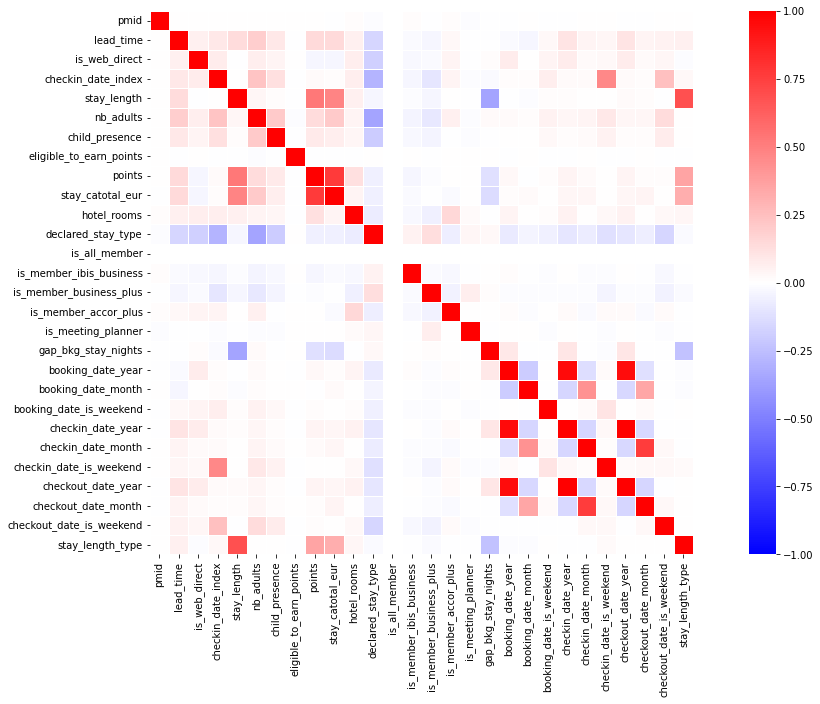

In [33]:
# Correlation des variables numeriques

# On supprime les lignes ou on a pas de valeur et la colonne calculé
df_corrnum = encoded_data[encoded_data['declared_stay_type']!='None']
df_corrnum = df_corrnum.drop(['calculated_stay_type'], axis = 1)

# On remplace les categories par des variables numeriques
df_corrnum = df_corrnum.replace(['business'], 1)
df_corrnum = df_corrnum.replace(['leisure'], 0)

# Extraction des variables numeriques
X_num = df_corrnum.select_dtypes(include=['int64','float64','bool','int32'])
X_num.info()

fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(X_num.corr(), annot= False, cmap= 'bwr',vmin= -1, vmax= 1, square= True, linewidths= 0.5);

In [34]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, SelectFromModel, f_regression, mutual_info_regression, RFE, RFECV
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import StandardScaler

# SelectKBest
X_num = X_num.drop(['declared_stay_type'], axis = 1)
y = df_corrnum['declared_stay_type']

fvalue_Best = SelectKBest(f_regression, k=5)
X_kbest = fvalue_Best.fit_transform(X_num, y)

print('Original number of features:', X_num.shape)
print('Reduced number of features:', X_kbest.shape)

mask = fvalue_Best.get_support()
new_features = X_num.columns[mask]
print(new_features)

Original number of features: (228692, 27)
Reduced number of features: (228692, 5)
Index(['is_web_direct', 'checkin_date_index', 'nb_adults', 'child_presence',
       'checkout_date_is_weekend'],
      dtype='object')


C:\Users\jean_\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in divide
  correlation_coefficient /= X_norms
C:\Users\jean_\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:358: RuntimeWarning: invalid value encountered in divide
  f_statistic = corr_coef_squared / (1 - corr_coef_squared) * deg_of_freedom


{'alpha': 0.1111111111111111}


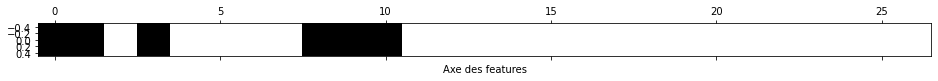

Index(['pmid', 'lead_time', 'checkin_date_index', 'points', 'stay_catotal_eur',
       'hotel_rooms'],
      dtype='object')


In [35]:
# SelectFromModel
crossval = KFold(n_splits = 5, random_state = 2, shuffle = True)

lasso = Lasso(alpha = 1)
model = SelectFromModel(estimator = lasso, threshold = 1e-10)
model.fit(X_num, y)

# La difficulté de ces techniques est alors de choisir judicieusement le paramètre de régularisation.
# Creation d'une grille et utilisation d'un GridSearchCV pour rechercher le meilleur parametre alpha
alpha_grid = {'alpha':[1/i for i in range(1,10)]}
grid = GridSearchCV(estimator = lasso, param_grid = alpha_grid, cv=crossval, scoring = 'neg_mean_squared_error')
grid.fit(X_num, y)
print(grid.best_params_)

# Selection des features en utilisant le best param
sel = SelectFromModel(estimator = grid.best_estimator_, threshold = 1e-10, prefit = True)
mask = sel.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

new_features = X_num.columns[mask]
print(new_features)

In [36]:
# On s'interesse aux modalités de chaque colonne categorielle
uniqueValues = encoded_data.select_dtypes(include=['object']).nunique()
print(uniqueValues)

booking_status               3
hotel_brand                 46
hotel_brand_positionning    24
hotel_sales_organisation     8
hotel_class                 10
hotel_location_type          4
hotel_continent              7
hotel_euro_market           10
environment_type             5
declared_stay_type           3
calculated_stay_type         2
type_member                 13
booking_date_day_name        7
checkin_date_day_name        7
checkout_date_day_name       7
nb_adults_cat                4
dtype: int64


In [37]:
# Dictionnary

replacement_positioning = {  
    'IBS' : 'Economy',
    'BKF' : 'Economy',
    'IBH' : 'Economy',
    'IBB' : 'Economy',
    'GRE' : 'Economy',
    'ADG' : 'Economy',
    'HOF' : 'Economy',
    'NOV' : 'Midscale', 
    'SUI' : 'Midscale',
    'MER' : 'Midscale',
    'SAM' : 'Midscale',
    'AHM' : 'Midscale',
    'TRI' : 'Midscale',
    'MTA' : 'Midscale',
    '21C' : 'Midscale', 
    'MSH' : 'Midscale',
    'BME' : 'Midscale',
    'MOL' : 'Midscale',
    'NOL' : 'Midscale',
    'MGS' : 'Luxury and Upscale',  
    'ADA' : 'Luxury and Upscale',  
    'SOL' : 'Luxury and Upscale', 
    'SEB' : 'Luxury and Upscale', 
    'MGA' : 'Luxury and Upscale', 
    'SOF' : 'Luxury and Upscale',
    'FAI' : 'Luxury and Upscale',
    'SWI' : 'Luxury and Upscale',
    'PUL' : 'Luxury and Upscale',
    'RAF' : 'Luxury and Upscale',
    'ART' : 'Luxury and Upscale',
    'CAS' : 'Luxury and Upscale',
    'MOV' : 'Luxury and Upscale',
    'MEI' : 'Luxury and Upscale',
    'ANG' : 'Luxury and Upscale',
    'PEP' : 'Luxury and Upscale',
    'SO'  : 'Luxury and Upscale',
    'SO/' : 'Luxury and Upscale',
    'SOR' : 'Luxury and Upscale',
    'SWL' : 'Luxury and Upscale',
    'MEL' : 'Luxury and Upscale',
    'TOR' : 'Luxury and Upscale',
    'FAE' : 'Luxury and Upscale'
}

# New colomn Hotel Brand Positionning to replace Brand by Replacement Positioning
encoded_data['hotel_brand_positionning'].replace(replacement_positioning, inplace=True)

# Check brand repartition
encoded_data['hotel_brand_positionning'].value_counts()

C:\Users\jean_\AppData\Local\Temp\ipykernel_18024\1550235807.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_data['hotel_brand_positionning'].replace(replacement_positioning, inplace=True)


Midscale              163466
Economy               161185
Luxury and Upscale     64063
Name: hotel_brand_positionning, dtype: int64

In [38]:
# Extraction des variables categoriels
X_cat = encoded_data.select_dtypes(include=['object'])
X_cat = X_cat.drop(['calculated_stay_type'], axis = 1)

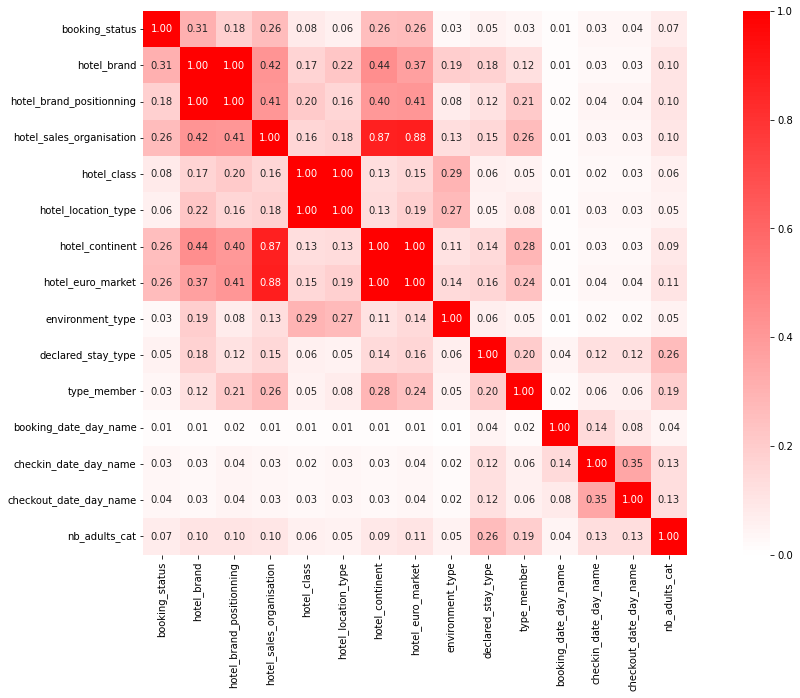

In [39]:
from dython.nominal import associations
from dython.nominal import identify_nominal_columns

cmap = sns.color_palette("bwr", as_cmap=True)
categorical_df = X_cat.copy()
categorical_correlation= associations(categorical_df, filename= 'categorical_correlation.png', figsize=(20,10), cmap=cmap)

In [40]:
from scipy.stats import chi2_contingency

table_contingence = pd.crosstab(encoded_data['hotel_brand'],encoded_data['declared_stay_type'])
table_contingence

declared_stay_type,None,business,leisure
hotel_brand,,,
21c MUSEUM HOTELS,13,26,80
25HOURS,30,147,395
ADAGIO,1223,531,1567
ADAGIO ACCESS,631,454,899
ADAGIO PREMIUM,14,5,13
ALL SEASONS,20,4,16
ART SERIES,46,29,73
BANYAN TREE,43,4,20
BREAKFREE,48,12,116


In [41]:
resultat_chi2 = chi2_contingency(table_contingence)
print("Statistique du test : ", resultat_chi2[0])
print("p-value : ", resultat_chi2[1])
print("Degré de liberté : ", resultat_chi2[2])

Statistique du test :  24425.26463112137
p-value :  0.0
Degré de liberté :  90


In [12]:
encoded_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388714 entries, 0 to 499998
Data columns (total 40 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   pmid                      388714 non-null  int64  
 1   lead_time                 388714 non-null  float64
 2   is_web_direct             388714 non-null  int32  
 3   checkin_date_index        388714 non-null  int64  
 4   stay_length               388714 non-null  int64  
 5   booking_status            388714 non-null  object 
 6   nb_adults                 388714 non-null  float64
 7   child_presence            388714 non-null  int32  
 8   eligible_to_earn_points   388714 non-null  int32  
 9   points                    388714 non-null  int64  
 10  stay_catotal_eur          388714 non-null  float64
 11  hotel_brand               388714 non-null  object 
 12  hotel_brand_positionning  388714 non-null  object 
 13  hotel_rooms               388714 non-null  i

In [15]:
# Creation of training, validation and test games
feature_data = encoded_data[encoded_data['declared_stay_type']!='None']
target = feature_data['declared_stay_type']
to_drop = ['declared_stay_type', 'calculated_stay_type']
feature_data = feature_data.drop(to_drop,axis=1)

to_drop_select = [
#'pmid',
#'lead_time',
#is_web_direct', 
#'checkin_date_index', 
#'nb_adults', 
#'child_presence',
#'points', 
#'stay_catotal_eur',
#'hotel_brand',
#'hotel_rooms',
#'hotel_sales_organisation',
#'type_member',
#'checkout_date_is_weekend',
#'hotel_euro_market',
#'stay_length', 
#'eligible_to_earn_points',
#'is_all_member',
#'is_member_ibis_business',
#'is_member_business_plus',
#'is_member_accor_plus',
#'is_meeting_planner',
#'gap_bkg_stay_nights',
#'booking_date_year',
#'booking_date_month',
#'booking_date_is_weekend',
#'checkin_date_year',
#'checkin_date_month',
#'checkin_date_is_weekend',
#'checkout_date_year',
#'checkout_date_month',
##'stay_length_type',
#'hotel_brand_positionning',
#'hotel_class',
#'hotel_location_type',
#'hotel_continent',       
#'environment_type',
'booking_date_day_name',
#'checkin_date_day_name',
#'checkout_date_day_name',
#'booking_status',
##'nb_adults_cat'
]

feature_data = feature_data.drop(to_drop_select,axis=1)
feature_data.info()

feature_data = pd.get_dummies(feature_data)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228692 entries, 0 to 499994
Data columns (total 37 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   pmid                      228692 non-null  int64  
 1   lead_time                 228692 non-null  float64
 2   is_web_direct             228692 non-null  int32  
 3   checkin_date_index        228692 non-null  int64  
 4   stay_length               228692 non-null  int64  
 5   booking_status            228692 non-null  object 
 6   nb_adults                 228692 non-null  float64
 7   child_presence            228692 non-null  int32  
 8   eligible_to_earn_points   228692 non-null  int32  
 9   points                    228692 non-null  int64  
 10  stay_catotal_eur          228692 non-null  float64
 11  hotel_brand               228692 non-null  object 
 12  hotel_brand_positionning  228692 non-null  object 
 13  hotel_rooms               228692 non-null  i

In [61]:
feature_data.head()

,pmid,lead_time,is_web_direct,checkin_date_index,stay_length,nb_adults,child_presence,eligible_to_earn_points,points,stay_catotal_eur,...,checkin_date_day_name_Thursday,checkin_date_day_name_Tuesday,checkin_date_day_name_Wednesday,checkout_date_day_name_Friday,checkout_date_day_name_Monday,checkout_date_day_name_Saturday,checkout_date_day_name_Sunday,checkout_date_day_name_Thursday,checkout_date_day_name_Tuesday,checkout_date_day_name_Wednesday
0,1,6.0,1,2,2,1.0,0,1,226,249.15,...,0,1,0,0,0,0,0,1,0,0
3,1,12.0,1,2,2,1.0,0,1,498,199.02,...,0,0,0,0,0,0,0,0,0,1
4,1,24.0,1,5,1,1.0,0,1,142,113.80,...,0,0,0,0,1,0,0,0,0,0
5,1,11.0,1,7,1,1.0,0,1,145,116.06,...,0,0,0,0,1,0,0,0,0,0
6,1,8.0,1,2,1,1.0,0,1,115,126.30,...,0,1,0,0,0,0,0,0,0,1


In [62]:
target.head()

0    business
3     leisure
4     leisure
5    business
6    business
Name: declared_stay_type, dtype: object

In [63]:
feature_data.info()
target.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 228692 entries, 0 to 499994
Columns: 148 entries, pmid to checkout_date_day_name_Wednesday
dtypes: float64(6), int32(6), int64(14), uint8(122)
memory usage: 68.5 MB
<class 'pandas.core.series.Series'>
Int64Index: 228692 entries, 0 to 499994
Series name: declared_stay_type
Non-Null Count   Dtype 
--------------   ----- 
228692 non-null  object
dtypes: object(1)
memory usage: 3.5+ MB


In [16]:
# We will keep 20% of the data for the test set
X_train, X_test, y_train, y_test= train_test_split(feature_data, target, test_size= 0.2, random_state=321)

In [17]:
scaler= StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [18]:
# Classification method : Logistic Regression simple
from sklearn.metrics import confusion_matrix

clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)

# Evaluation 
print(classification_report(y_true= y_test, y_pred=y_pred))

print(clf.score(X_test, y_test))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

    business       0.69      0.62      0.65     15605
     leisure       0.81      0.86      0.83     30134

    accuracy                           0.78     45739
   macro avg       0.75      0.74      0.74     45739
weighted avg       0.77      0.78      0.77     45739

0.7760991713854697


Classe prédite,business,leisure
Classe réelle,,
business,9693,5912
leisure,4329,25805


In [49]:
# Classification method : Logistic Regression avec GridSearch
clf_lr= LogisticRegression()
param_grid_lr = {'solver': ['liblinear', 'lbfgs'],'C': np.linspace(0.1,1,10)}
gcv_lr = GridSearchCV(estimator=clf_lr, param_grid=param_grid_lr, cv=3)
grille = gcv_lr.fit(X_train, y_train)

C:\Users\jean_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jean_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\jean_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jean_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [46]:
print(pd.DataFrame.from_dict(grille.cv_results_).loc[:,['params', 'mean_test_score']])

# Récupérer le meilleur paramètre
print(gcv_lr.best_params_)

# Evaluation 
y_pred2 = gcv_lr.predict(X_test)
print(classification_report(y_test, y_pred2))

print(gcv_lr.score(X_test, y_test))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

                                               params  mean_test_score
0                   {'C': 0.1, 'solver': 'liblinear'}         0.760862
1                       {'C': 0.1, 'solver': 'lbfgs'}         0.760687
2                   {'C': 0.2, 'solver': 'liblinear'}         0.765601
3                       {'C': 0.2, 'solver': 'lbfgs'}         0.765508
4   {'C': 0.30000000000000004, 'solver': 'liblinear'}         0.768033
5       {'C': 0.30000000000000004, 'solver': 'lbfgs'}         0.767416
6                   {'C': 0.4, 'solver': 'liblinear'}         0.769378
7                       {'C': 0.4, 'solver': 'lbfgs'}         0.768902
8                   {'C': 0.5, 'solver': 'liblinear'}         0.770477
9                       {'C': 0.5, 'solver': 'lbfgs'}         0.769323
10                  {'C': 0.6, 'solver': 'liblinear'}         0.771346
11                      {'C': 0.6, 'solver': 'lbfgs'}         0.770553
12   {'C': 0.7000000000000001, 'solver': 'liblinear'}         0.771734
13    

Classe prédite,business,leisure
Classe réelle,,
business,9488,6117
leisure,4179,25955


In [19]:
# Classification method : Random Forest simple
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(n_jobs=-1, random_state=321)
clf.fit(X_train, y_train) 

y_pred = clf.predict(X_test)

# Evaluation 
print(classification_report(y_test, y_pred))

print(clf.score(X_test, y_test))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

              precision    recall  f1-score   support

    business       0.75      0.65      0.70     15605
     leisure       0.83      0.89      0.86     30134

    accuracy                           0.81     45739
   macro avg       0.79      0.77      0.78     45739
weighted avg       0.80      0.81      0.80     45739

0.8071230241150877


Classe prédite,business,leisure
Classe réelle,,
business,10104,5501
leisure,3321,26813


In [47]:
# Classification method : Random Forest 
clf_rf= RandomForestClassifier()
param_grid_rf = [{'n_estimators': [10, 50, 100],
                   'min_samples_leaf': [1, 3, 5],
                   'max_features': ['sqrt', 'log2']}]
gcv_rf = GridSearchCV(clf_rf, param_grid_rf, cv=3)
grille2 = gcv_rf.fit(X_train, y_train)

In [48]:
print(pd.DataFrame.from_dict(grille2.cv_results_).loc[:,['params', 'mean_test_score']])

# Récupérer le meilleur paramètre
print(gcv_rf.best_params_)

# Evaluation 
y_pred2 = gcv_rf.predict(X_test)
print(classification_report(y_test, y_pred2))

print(gcv_rf.score(X_test, y_test))
pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])

                                               params  mean_test_score
0   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.780747
1   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.802654
2   {'max_features': 'sqrt', 'min_samples_leaf': 1...         0.805316
3   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.790821
4   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.802151
5   {'max_features': 'sqrt', 'min_samples_leaf': 3...         0.803895
6   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.793034
7   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.801867
8   {'max_features': 'sqrt', 'min_samples_leaf': 5...         0.801342
9   {'max_features': 'log2', 'min_samples_leaf': 1...         0.775330
10  {'max_features': 'log2', 'min_samples_leaf': 1...         0.798489
11  {'max_features': 'log2', 'min_samples_leaf': 1...         0.801747
12  {'max_features': 'log2', 'min_samples_leaf': 3...         0.786880
13  {'

Classe prédite,business,leisure
Classe réelle,,
business,10265,5340
leisure,3353,26781


In [20]:
# Classification method : XGBOOST simple
import xgboost as xgb
from sklearn.metrics import accuracy_score

targetXGB = target
targetXGB = targetXGB.replace(['business'], 1)
targetXGB = targetXGB.replace(['leisure'], 0)

X_trainXGB, X_testXGB, y_trainXGB, y_testXGB = train_test_split(feature_data, targetXGB, test_size = 0.2, random_state=321)

scaler= StandardScaler()
X_trainXGB = scaler.fit_transform(X_trainXGB)
X_testXGB = scaler.transform(X_testXGB)

eval_set = [(X_trainXGB, y_trainXGB),(X_testXGB,y_testXGB)]

xgb_classifier = xgb.XGBClassifier(
booster="gbtree",
subsample=1,
colsample_bytree=1,
min_child_weight=1,
max_depth=6,
learning_rate=0.3,
n_estimators=100,
eval_metric="error",
early_stopping_rounds=10)
xgb_classifier.fit(X_trainXGB, y_trainXGB, eval_set=eval_set, verbose=0)
predictions = xgb_classifier.predict(X_testXGB)

# Evaluation 
print(classification_report(y_testXGB, predictions))

print("Accuracy of Model: ", accuracy_score(y_testXGB, predictions))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86     30134
           1       0.74      0.68      0.71     15605

    accuracy                           0.81     45739
   macro avg       0.79      0.78      0.78     45739
weighted avg       0.81      0.81      0.81     45739

Accuracy of Model:  0.8100089639038894


In [52]:
# Classification method : XGBOOST

PARAMETERS = {"subsample":[0.5, 0.75, 1],
"colsample_bytree":[0.5, 0.75, 1],
"max_depth":[2, 6, 12],
"min_child_weight":[1,5,15],
"learning_rate":[0.3, 0.1, 0.03],
"n_estimators":[100]}

#Initialise XGBoost Model
xgb_classifier = xgb.XGBClassifier(n_estimators=100, n_jobs=-1, early_stopping_rounds=10, eval_metric="error")
xgb_classifier_gs = GridSearchCV(xgb_classifier, param_grid=PARAMETERS, cv=3, scoring="accuracy")
xgb_classifier_gs.fit(X_trainXGB, y_trainXGB, eval_set=eval_set, verbose=0)
print(xgb_classifier_gs.best_params_)

predictions = xgb_classifier_gs.predict(X_testXGB)
print('Accuracy:',accuracy_score(y_testXGB, predictions))

{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 12, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 1}
Accuracy: 0.8198255318218588


In [22]:
# Classification method : XGBOOST simple avec parametres optimisées
import xgboost as xgb
from sklearn.metrics import accuracy_score

targetXGB = target
targetXGB = targetXGB.replace(['business'], 1)
targetXGB = targetXGB.replace(['leisure'], 0)

X_trainXGB, X_testXGB, y_trainXGB, y_testXGB = train_test_split(feature_data, targetXGB, test_size = 0.2, random_state=321)

scaler= StandardScaler()
X_trainXGB = scaler.fit_transform(X_trainXGB)
X_testXGB = scaler.transform(X_testXGB)

eval_set = [(X_trainXGB, y_trainXGB),(X_testXGB,y_testXGB)]

xgb_classifier = xgb.XGBClassifier(
booster="gbtree",
subsample=1,
colsample_bytree=1,
min_child_weight=1,
max_depth=12,
learning_rate=0.1,
n_estimators=200,
eval_metric="error",
early_stopping_rounds=10)
xgb_classifier.fit(X_trainXGB, y_trainXGB, eval_set=eval_set, verbose=0)
predictions = xgb_classifier.predict(X_testXGB)

# Evaluation 
print(classification_report(y_testXGB, predictions))

print("Accuracy of Model: ", accuracy_score(y_testXGB, predictions))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     30134
           1       0.76      0.70      0.73     15605

    accuracy                           0.82     45739
   macro avg       0.81      0.79      0.80     45739
weighted avg       0.82      0.82      0.82     45739

Accuracy of Model:  0.8233673670172064


In [53]:
my_list = list(feature_data)
print (my_list)

['pmid', 'lead_time', 'is_web_direct', 'checkin_date_index', 'stay_length', 'nb_adults', 'child_presence', 'eligible_to_earn_points', 'points', 'stay_catotal_eur', 'hotel_rooms', 'is_all_member', 'is_member_ibis_business', 'is_member_business_plus', 'is_member_accor_plus', 'is_meeting_planner', 'gap_bkg_stay_nights', 'booking_date_year', 'booking_date_month', 'booking_date_is_weekend', 'checkin_date_year', 'checkin_date_month', 'checkin_date_is_weekend', 'checkout_date_year', 'checkout_date_month', 'checkout_date_is_weekend', 'booking_status_A', 'booking_status_M', 'booking_status_N', 'hotel_brand_21c MUSEUM HOTELS', 'hotel_brand_25HOURS', 'hotel_brand_ADAGIO', 'hotel_brand_ADAGIO ACCESS', 'hotel_brand_ADAGIO PREMIUM', 'hotel_brand_ALL SEASONS', 'hotel_brand_ART SERIES', 'hotel_brand_BANYAN TREE', 'hotel_brand_BREAKFREE', 'hotel_brand_BY MERCURE', 'hotel_brand_CASSIA', 'hotel_brand_FAENA', 'hotel_brand_FAIRMONT', 'hotel_brand_GRAND MERCURE', 'hotel_brand_GREET', 'hotel_brand_HYDE', 'ho

In [47]:
from sklearn.feature_selection import RFE
from xgboost.sklearn import XGBClassifier

estimator = XGBClassifier()
rfe = RFE(estimator, step=1, n_features_to_select=3)
rfe = rfe.fit(X_trainXGB, y_trainXGB)

print(rfe.support_)
print(rfe.ranking_)

[False False  True  True False  True False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False]
[ 27  33   1   1  25   1   2 123  45  50  61 129  49  13  26  44  23  31
  19  73  30  32 101   3 

In [47]:
# Recursive feature elimination
from xgboost.sklearn import XGBClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import f1_score, make_scorer

f1_scorer = make_scorer(f1_score, average='binary', pos_label=1)

estimator = XGBClassifier()
selector = RFECV(estimator, step=1, min_features_to_select=1, cv=5, scoring=f1_scorer)

In [48]:
#fit the model, get a rank of the variables, and a matrix of the selected X variables
selector = selector.fit(X_trainXGB, y_trainXGB)

In [49]:
print(selector.support_)
print(selector.ranking_)

[ True  True  True  True  True  True  True False  True  True  True False
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True False  True  True  True False False False
 False False False False False False  True False False  True  True  True
 False  True False False  True False  True False False False  True  True
 False False  True False False False False False  True False False False
 False False False  True  True  True  True  True False  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True False False  True False
 False  True  True False False False  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
 False False  True  True  True False  True  True  True False False  True
  True  True  True  True]
[ 1  1  1  1  1  1  1 23  1  1  1 31  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 30  1  1 

In [56]:
to_drop_select_XGBRFE = ['eligible_to_earn_points', 
'is_all_member', 
'hotel_brand_21c MUSEUM HOTELS', 
'hotel_brand_ADAGIO PREMIUM', 'hotel_brand_ALL SEASONS', 'hotel_brand_ART SERIES', 'hotel_brand_BANYAN TREE', 'hotel_brand_BREAKFREE', 'hotel_brand_BY MERCURE', 'hotel_brand_CASSIA', 'hotel_brand_FAENA', 'hotel_brand_FAIRMONT', 
'hotel_brand_GREET', 'hotel_brand_HYDE', 
'hotel_brand_JO&JOE', 
'hotel_brand_MANTIS', 'hotel_brand_MANTRA', 
'hotel_brand_MGALLERY', 
'hotel_brand_MONDRIAN', 'hotel_brand_MOVENPICK', 'hotel_brand_MOVENPICK LIVING', 
'hotel_brand_OTHER BRAND', 'hotel_brand_PEPPERS', 
'hotel_brand_RAFFLES', 'hotel_brand_REDBURY HOTELS', 'hotel_brand_RIXOS HOTELS', 'hotel_brand_SLS', 'hotel_brand_SO/',  
'hotel_brand_SOFITEL LEGEND', 'hotel_brand_SOFITEL SERVICED RESIDENCES', 'hotel_brand_SWISSOTEL', 'hotel_brand_SWISSOTEL LIVING', 'hotel_brand_THE SEBEL', 'hotel_brand_TRIBE', 
'hotel_sales_organisation_North & Central America, Caribbe', 
'hotel_location_type_Unknown Location', 
'hotel_continent_NORTH AMERICA', 'hotel_continent_PACIFIC', 
'hotel_euro_market_AFRICA', 'hotel_euro_market_ASIA', 
'hotel_euro_market_MIDDLE EAST', 'hotel_euro_market_NORTH AMERICA', 'hotel_euro_market_PACIFIC', 
'hotel_euro_market_SOUTH AMERICA', 
'type_member_BUSINESS PLUS', 'type_member_ibis BUSINESS', 
'checkin_date_day_name_Sunday', 
'checkout_date_day_name_Friday', 'checkout_date_day_name_Monday']

feature_data_Business = feature_data.drop(to_drop_select_XGBRFE,axis=1)

In [59]:
X_trainXGB, X_testXGB, y_trainXGB, y_testXGB = train_test_split(feature_data_Business, targetXGB, test_size = 0.2, random_state=321)

scaler= StandardScaler()
X_trainXGB = scaler.fit_transform(X_trainXGB)
X_testXGB = scaler.transform(X_testXGB)

eval_set = [(X_trainXGB, y_trainXGB),(X_testXGB,y_testXGB)]

xgb_classifier = xgb.XGBClassifier(
booster="gbtree",
subsample=1,
colsample_bytree=1,
min_child_weight=1,
max_depth=12,
learning_rate=0.1,
n_estimators=200,
eval_metric="error",
early_stopping_rounds=10)
xgb_classifier.fit(X_trainXGB, y_trainXGB, eval_set=eval_set, verbose=0)
predictions = xgb_classifier.predict(X_testXGB)

# Evaluation 
print(classification_report(y_testXGB, predictions))

print("Accuracy of Model: ", accuracy_score(y_testXGB, predictions))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     30134
           1       0.76      0.70      0.73     15605

    accuracy                           0.82     45739
   macro avg       0.80      0.79      0.80     45739
weighted avg       0.82      0.82      0.82     45739

Accuracy of Model:  0.8211810489953869


In [51]:
##################################################
# Augmentation du F1 Score pour la partie Business
##################################################

# Test ajustement du jeu par SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler,  ClusterCentroids

smo = SMOTE()
X_trainSMO, y_trainSMO = smo.fit_resample(X_trainXGB, y_trainXGB)
print('Classes échantillon SMOTE :', dict(pd.Series(y_trainSMO).value_counts()))

Classes échantillon SMOTE : {1: 120413, 0: 120413}


In [52]:
eval_setSMO = [(X_trainSMO, y_trainSMO),(X_testXGB,y_testXGB)]

xgb_classifierSMO = xgb.XGBClassifier(
booster="gbtree",
subsample=1,
colsample_bytree=1,
min_child_weight=1,
max_depth=12,
learning_rate=0.1,
n_estimators=200,
eval_metric="error",
early_stopping_rounds=10)
xgb_classifierSMO.fit(X_trainSMO, y_trainSMO, eval_set=eval_setSMO, verbose=0)
predictionsSMO = xgb_classifierSMO.predict(X_testXGB)

# Evaluation 
print(classification_report(y_testXGB, predictionsSMO))

print("Accuracy of Model: ", accuracy_score(y_testXGB, predictionsSMO))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87     30134
           1       0.75      0.70      0.73     15605

    accuracy                           0.82     45739
   macro avg       0.80      0.79      0.80     45739
weighted avg       0.82      0.82      0.82     45739

Accuracy of Model:  0.8205688799492774


In [53]:
# Test ajustement du jeu par Undersampling
rUs = RandomUnderSampler()
X_trainRU, y_trainRU = rUs.fit_resample(X_trainXGB, y_trainXGB)
print('Classes échantillon undersampled :', dict(pd.Series(y_trainRU).value_counts()))

Classes échantillon undersampled : {0: 62540, 1: 62540}


In [54]:
eval_setRU = [(X_trainRU, y_trainRU),(X_testXGB,y_testXGB)]

xgb_classifierRU = xgb.XGBClassifier(
booster="gbtree",
subsample=1,
colsample_bytree=1,
min_child_weight=1,
max_depth=12,
learning_rate=0.1,
n_estimators=200,
eval_metric="logloss",#"rmse",#"error",
early_stopping_rounds=10)
xgb_classifierRU.fit(X_trainRU, y_trainRU, eval_set=eval_setRU, verbose=0)
predictionsRU = xgb_classifierRU.predict(X_testXGB)

# Evaluation 
print(classification_report(y_testXGB, predictionsRU))

print("Accuracy of Model: ", accuracy_score(y_testXGB, predictionsRU))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84     30134
           1       0.68      0.81      0.74     15605

    accuracy                           0.80     45739
   macro avg       0.78      0.81      0.79     45739
weighted avg       0.82      0.80      0.81     45739

Accuracy of Model:  0.8030564725945036


In [57]:
# Test par ajustement du param scale_pos_weight
import xgboost as xgb
from sklearn.metrics import accuracy_score

targetXGB = target
targetXGB = targetXGB.replace(['business'], 1)
targetXGB = targetXGB.replace(['leisure'], 0)

X_trainXGB, X_testXGB, y_trainXGB, y_testXGB = train_test_split(feature_data, targetXGB, test_size = 0.2, random_state=321)

eval_set = [(X_trainXGB, y_trainXGB),(X_testXGB,y_testXGB)]

xgb_classifier = xgb.XGBClassifier(
scale_pos_weight=200,
booster="gbtree",
subsample=1,
colsample_bytree=1,
min_child_weight=1,
max_depth=12,
learning_rate=0.1,
n_estimators=200,
eval_metric="error",
early_stopping_rounds=10)
xgb_classifier.fit(X_trainXGB, y_trainXGB, eval_set=eval_set, verbose=0)
predictions = xgb_classifier.predict(X_testXGB)

# Evaluation 
print(classification_report(y_testXGB, predictions))

print("Accuracy of Model: ", accuracy_score(y_testXGB, predictions))

              precision    recall  f1-score   support

           0       0.94      0.44      0.60     30134
           1       0.47      0.95      0.63     15605

    accuracy                           0.61     45739
   macro avg       0.70      0.69      0.61     45739
weighted avg       0.78      0.61      0.61     45739

Accuracy of Model:  0.6138962373466844


In [103]:
# Semi supervise
# Liste des objets pour dummifier
encoded_data.select_dtypes(include=['object']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388714 entries, 0 to 499998
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   booking_status            388714 non-null  object
 1   hotel_brand               388714 non-null  object
 2   hotel_brand_positionning  388714 non-null  object
 3   hotel_sales_organisation  388714 non-null  object
 4   hotel_class               388714 non-null  object
 5   hotel_location_type       388714 non-null  object
 6   hotel_continent           388714 non-null  object
 7   hotel_euro_market         388714 non-null  object
 8   environment_type          388714 non-null  object
 9   calculated_stay_type      388714 non-null  object
 10  type_member               388714 non-null  object
 11  booking_date_day_name     388714 non-null  object
 12  checkin_date_day_name     388714 non-null  object
 13  checkout_date_day_name    388714 non-null  object
 14  nb_a

In [104]:
encoded_data_semi = encoded_data

encoded_data_semi['declared_stay_type'] = np.where(encoded_data_semi['declared_stay_type']=="None", -1, encoded_data_semi['declared_stay_type'])
encoded_data_semi['declared_stay_type'] = np.where(encoded_data_semi['declared_stay_type']=="business", 1, encoded_data_semi['declared_stay_type'])
encoded_data_semi['declared_stay_type'] = np.where(encoded_data_semi['declared_stay_type']=="leisure", 0, encoded_data_semi['declared_stay_type'])
encoded_data_semi['declared_stay_type'] = encoded_data_semi['declared_stay_type'].astype(float)
print("Declared_stay_type\n", encoded_data_semi['declared_stay_type'].value_counts(normalize=True))

Declared_stay_type
 -1.0    0.411670
 0.0    0.387295
 1.0    0.201035
Name: declared_stay_type, dtype: float64


C:\Users\jean_\AppData\Local\Temp\ipykernel_11784\2379481340.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_data_semi['declared_stay_type'] = np.where(encoded_data_semi['declared_stay_type']=="None", -1, encoded_data_semi['declared_stay_type'])
C:\Users\jean_\AppData\Local\Temp\ipykernel_11784\2379481340.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encoded_data_semi['declared_stay_type'] = np.where(encoded_data_semi['declared_stay_type']=="business", 1, encoded_data_semi['declared_stay_t

In [105]:
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['booking_status'], prefix='A'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['hotel_brand'], prefix='B'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['hotel_brand_positionning'], prefix='C'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['hotel_sales_organisation'], prefix='D'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['hotel_class'], prefix='E'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['hotel_location_type'], prefix='F'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['hotel_continent'], prefix='G'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['hotel_euro_market'], prefix='H'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['environment_type'], prefix='I'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['type_member'], prefix='J'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['booking_date_day_name'], prefix='K'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['checkin_date_day_name'], prefix='L'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['checkout_date_day_name'], prefix='M'))
encoded_data_semi = encoded_data_semi.join(pd.get_dummies(encoded_data_semi['nb_adults_cat'], prefix='N'))

to_drop = ['booking_status', 'hotel_brand', 'hotel_brand_positionning', 'hotel_sales_organisation', 'hotel_class', 
           'hotel_location_type', 'hotel_continent', 'hotel_euro_market', 'environment_type', 'type_member',
           'booking_date_day_name', 'checkin_date_day_name', 'checkout_date_day_name', 'nb_adults_cat', 
           'calculated_stay_type']
encoded_data_semi = encoded_data_semi.drop(to_drop,axis=1)
encoded_data_semi.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 388714 entries, 0 to 499998
Columns: 162 entries, pmid to N_2.0
dtypes: float64(7), int32(6), int64(15), uint8(134)
memory usage: 134.8 MB


In [106]:
# Séparation des données labellisées et non labellisées
labeled_data = encoded_data_semi[encoded_data_semi['declared_stay_type']!=-1]
unlabeled_data = encoded_data_semi[encoded_data_semi['declared_stay_type']==-1]

# Décomposition des données en deux ensembles d'entraînement et de test.
# Le jeu d'entrainement contient les valeurs sans label
test = labeled_data.iloc[:20000,:]
train = pd.concat([labeled_data.iloc[20000:,:], unlabeled_data])

In [107]:
#Création des matrices de features et des données cibles pour les données d'entrainement et de test
X_test = test.drop('declared_stay_type', axis=1)
y_test = test['declared_stay_type']
X_train = train.drop('declared_stay_type', axis=1)
y_train = train['declared_stay_type']

In [108]:
# Création du classifier et construction du modèle sur les données d'entraînement
from sklearn.semi_supervised import LabelSpreading

label_model = LabelSpreading(n_neighbors=7, kernel='knn', max_iter=10, gamma=0.20)
label_model.fit(X_train, y_train)

C:\Users\jean_\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:316: ConvergenceWarning: max_iter=10 was reached without convergence.
  warnings.warn(


LabelSpreading(gamma=0.2, kernel='knn', max_iter=10)

In [109]:
# Calcul de la matrice de confusion
y_pred = label_model.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

C:\Users\jean_\anaconda3\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:222: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


Classes prédites,0.0,1.0
Classes réelles,,
0.0,12555,385
1.0,6837,223


In [111]:
from sklearn.metrics import cohen_kappa_score

# Calcul du coefficient Cohen Kappa
cohen_kappa_score(y_test, y_pred)

0.00231421106842733